In [2]:
import pandas as pd
import numpy as np
import quandl as ql

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.utils.extmath import svd_flip
from statsmodels.regression import linear_model
from statsmodels.tools import add_constant

In [91]:
#display plots full width
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [5]:
%matplotlib inline


In [6]:
#add your own API key from Quandl here (sign up on quandl for free)
ql.ApiConfig.api_key = "YOUR_KEY_HERE"

In [7]:
#get interest rate swaps from FRED on Quandl
a = ql.get("FRED/DSWP10").index

In [8]:
#Label columns with IRS years
df = pd.DataFrame(index=a,columns = ['1', '2', '3', '4', '5', '7', '10', '30'])

In [9]:
#get values from quandl Series and add to Dataframe
for i in ['1', '2', '3', '4', '5', '7', '10', '30']:
    df[i] = ql.get("FRED/DSWP" + i).VALUE
    

In [49]:
#select a 12 month (250) trading day period to work with
df1 = df['2014-12-03':'2015-12-03']

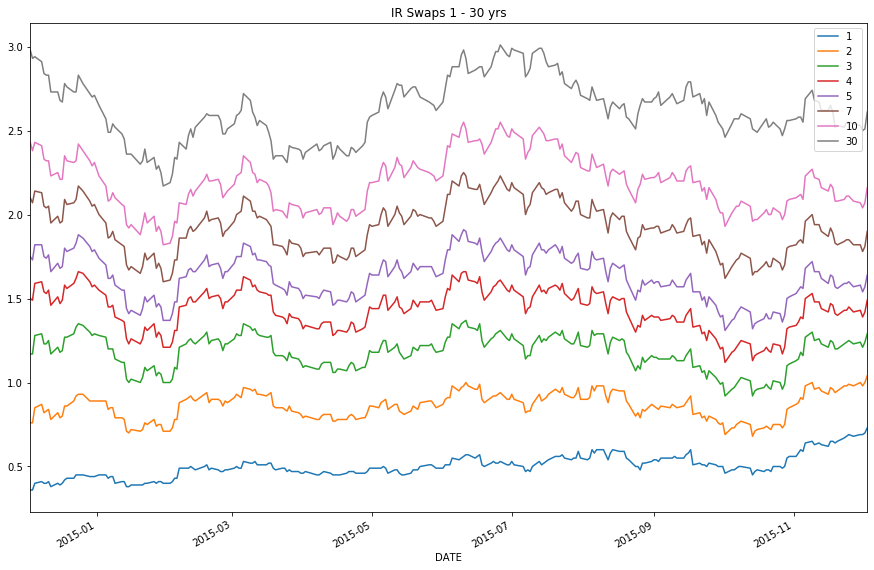

In [92]:
df1.plot(title='IR Swaps 1 - 30 yrs')

In [86]:
# Scale the data before passing to PCA algo (desgn choice - depends whether scaling / outliers matter)
X = df1
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

In [52]:

#x = pca.fit(df1)

In [87]:
#shows the top 3 PC's account for over 99% of total variance
print(np.round(x.explained_variance_ratio_,2))

[0.85 0.1  0.04 0.   0.   0.   0.   0.  ]


Text(0.5, 1.0, 'Explained variance of each PC')

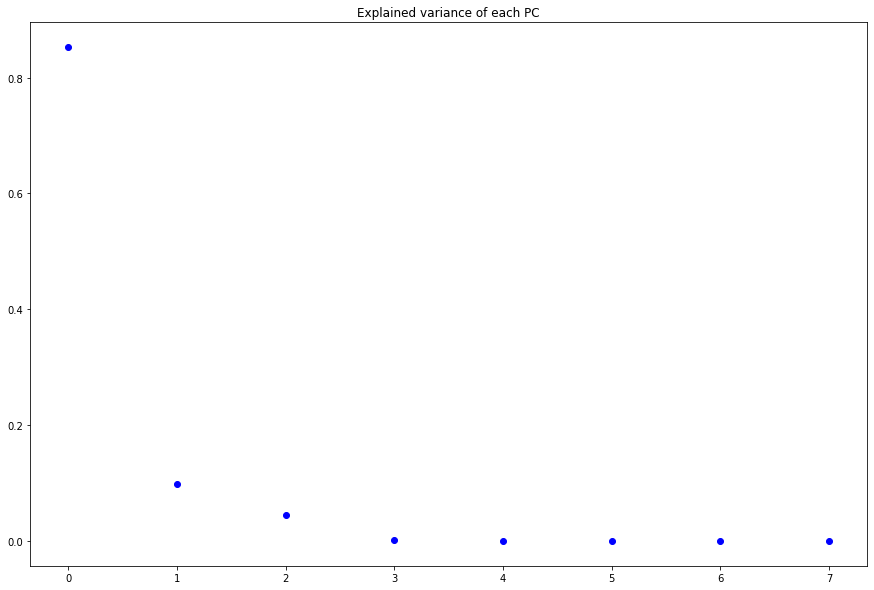

In [95]:
#by plotting the amount of variance explained by each PC we can see the top 3 account for around 99%
plt.plot(x.explained_variance_ratio_, 'bo')
plt.title('Explained variance of each PC')


In [55]:
df1.head()

,1,2,3,4,5,7,10,30
DATE,,,,,,,,
2014-12-03,0.36,0.76,1.17,1.50,1.75,2.10,2.43,2.98
2014-12-04,0.36,0.76,1.17,1.49,1.73,2.07,2.38,2.93
2014-12-05,0.40,0.85,1.28,1.59,1.82,2.14,2.43,2.94
2014-12-08,0.41,0.87,1.29,1.60,1.82,2.13,2.41,2.91
2014-12-09,0.40,0.82,1.23,1.54,1.75,2.05,2.33,2.84


In [56]:
corr_mat = df1.corr()
corr_mat.shape

In [58]:
#lets plot this matrix so its easier to interpret
corr_mat

,1,2,3,4,5,7,10,30
1,1.000000,0.728367,0.385359,0.242848,0.206410,0.222389,0.252265,0.259223
2,0.728367,1.000000,0.907395,0.822968,0.776310,0.715481,0.645833,0.507158
3,0.385359,0.907395,1.000000,0.981325,0.950188,0.874666,0.776135,0.601340
4,0.242848,0.822968,0.981325,1.000000,0.988935,0.931668,0.842502,0.676089
5,0.206410,0.776310,0.950188,0.988935,1.000000,0.972595,0.905892,0.760006
7,0.222389,0.715481,0.874666,0.931668,0.972595,1.000000,0.978361,0.880896
10,0.252265,0.645833,0.776135,0.842502,0.905892,0.978361,1.000000,0.955391
30,0.259223,0.507158,0.601340,0.676089,0.760006,0.880896,0.955391,1.000000


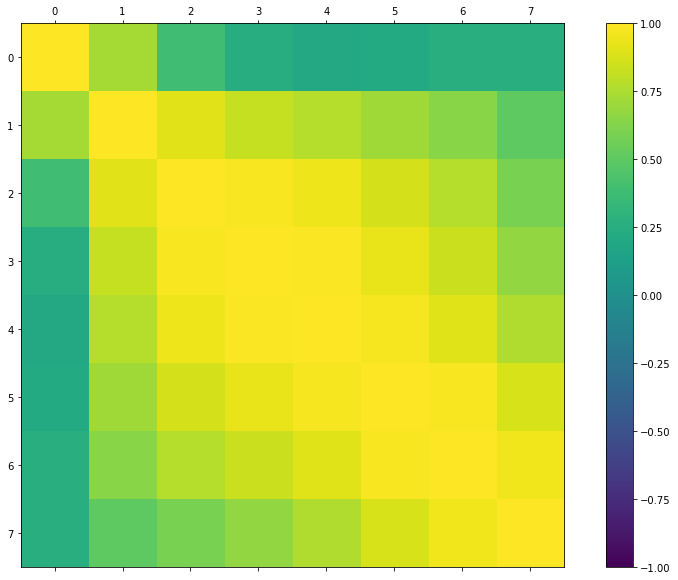

In [96]:
#correlation matrix shows high correleation amongst IR swaps - this shouldn't be a supprise as
#all IRS include  the shorter end yields - eg, 30yr includes 1yr, 2yr 3yr etc.
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr_mat, vmin=-1, vmax=1)

fig.colorbar(cax)


plt.show()

In [60]:
pca = PCA(n_components=8).fit(df1)
pca_samples = pca.transform(df1)

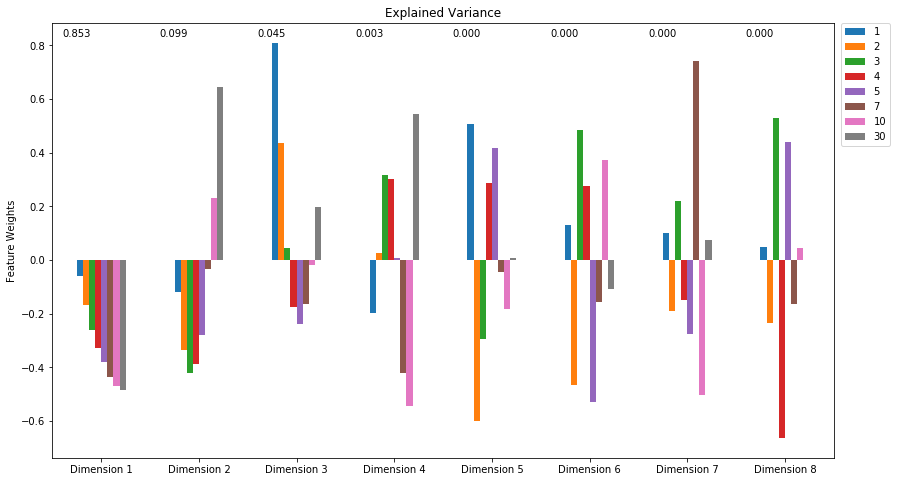

In [61]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)
    ax.set_title('Explained Variance')
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] - 0.05, "%.3f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(df1, pca)

In [24]:
pca = PCA(n_components=2).fit(df1)
reduced_data = pca.transform(df1)
pca_samples = pca.transform(df1)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

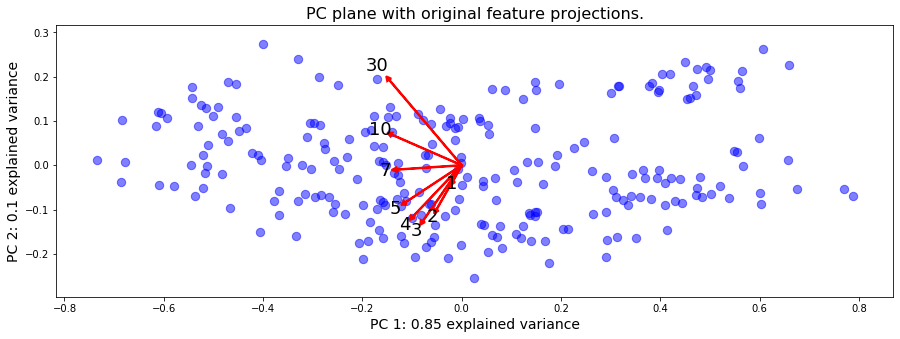

In [25]:
#plot loadings on top 2 PC (which account for most of the variance)
#we can see short and long end of curve lay mostly on PC2 (Slope) albeit in oposite directions
#the belly of the curve lays mostly on PC1 which represents shift.
def biplot(data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (15,5))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 0.30, 0.35,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.01, head_length=0.01, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, df1.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel(f'PC 1: {np.round(x.explained_variance_ratio_,2)[0]} explained variance', fontsize=14)
    ax.set_ylabel(f'PC 2: {np.round(x.explained_variance_ratio_,2)[1]} explained variance', fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(df1, reduced_data, pca)

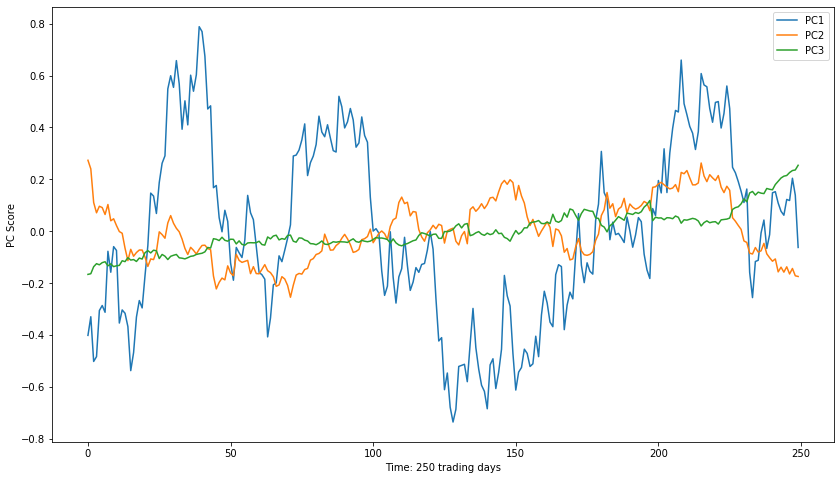

In [62]:
#plot PC scores for top 3 PC over time
pca = PCA(n_components=3).fit(df1)
reduced_data = pca.transform(df1)
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(reduced_data)
ax.set_xlabel('Time: 250 trading days')
ax.set_ylabel('PC Score')


ax.legend(['PC1','PC2','PC3'])

In [74]:
# Scale and transform PCA data then we can calculate loadings (sklearn doesnt have loadings func)
X = df1
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

In [80]:
#calculate loadings
q = pca.components_.T * np.sqrt(pca.explained_variance_)

In [ ]:
a = pd.DataFrame(q)
a.index = [1,2,3,4,5,7,10,30]
a.columns = ['PC1', 'PC2', 'PC3']

In [85]:
#all loadings for PC1 have same negative sign (signs are arbitrary in loadings) suggesting SHIFT.
#PC2 is positve at short end and negative at long end suggesting SLOPE (longend moves up while short end moves 
#down and vice verse)
#PC3 is negative at short and long but positive at belly suggesting CONVEXITY

#show results
a

,PC1,PC2,PC3
1,-0.405825,0.864066,-0.302931
2,-0.858204,0.494934,0.143292
3,-0.946850,0.110688,0.304948
4,-0.961004,-0.074158,0.271363
5,-0.974707,-0.161334,0.163835
7,-0.973951,-0.220073,-0.056669
10,-0.936413,-0.238292,-0.258706
30,-0.825301,-0.259565,-0.498970
